In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from classifier import *
import features as fe 
import utils as ut

In [102]:
X_train_face_img, X_train_nonface_img, X_test_img, y_train_face, y_train_nonface, y_test = ut.get_test_train_data()

### Testing AdaBoost

In [103]:
X_train_img = np.concatenate((X_train_face_img, X_train_nonface_img))
y_train = np.concatenate((y_train_face, y_train_nonface))
X_train_ada, y_train_ada = ut.random_subset(X_train_img, y_train, 100)
X_test_ada, y_test_ada = ut.random_subset(X_test_img, y_test, 100)

In [104]:
rect = fe.get_rectanges(19, 19)
no_rect = fe.get_no_rectangles(19, 19)
X_train_ada_fe = fe.par_feature_extraction_images(X_train_ada, rect, no_rect)
X_test_ada_fe = fe.par_feature_extraction_images(X_test_ada, rect, no_rect)

number_of cpus =  16
number_of cpus =  16


In [105]:
a = AdaBoostClassifier()
a.fit(X_train_ada_fe, y_train_ada, 2)

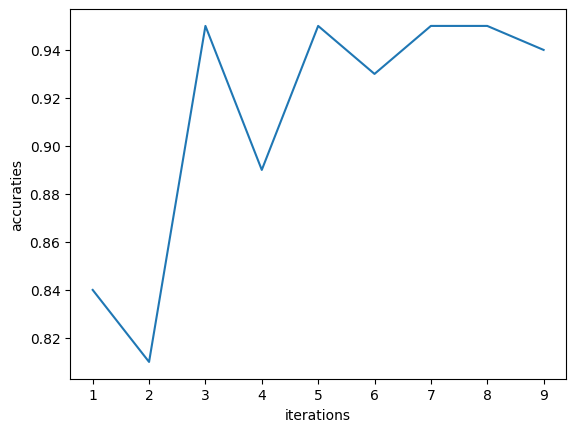

In [106]:
iters = list(range(1, 10))
accuracies = []
a = AdaBoostClassifier()
for iter in iters:
    a.fit(X_train_ada_fe, y_train_ada, iter)
    accuracy = a.score(X_test_ada_fe, y_test_ada)
    accuracies.append(accuracy)

plt.xlabel("iterations")
plt.ylabel("accuraties")
plt.plot(iters, accuracies)
plt.show()

In [107]:
print(a.threshold*0.98)
print(a.false_positive_rate(X_test_ada_fe, y_test_ada))
print(a.detection_rate(X_test_ada_fe, y_test_ada))
print(a.score(X_test_ada_fe, y_test_ada))

11.72857076929015
0.06
0.0
0.94


In [108]:
# split the training data into 10 folds
X_train_folds = np.array_split(X_train_ada_fe, 10)
y_train_folds = np.array_split(y_train_ada, 10)


In [113]:
f = 0.9
d = 0.9
F_target = 0.3
Threshold_retention = 0.99
Strong_Classifiers = []

def Cascade_Classifier(X_test,y_test, Strong_Classifiers):
    y_pred = np.zeros(len(X_test))
    no_of_negatives = np.sum(y_test == 0)
    total_test_y = len(y_test)
    for i in range(len(Strong_Classifiers)):
        print(y_pred.shape, X_test.shape,y_test.shape)
        y_pred = Strong_Classifiers[i].predict(X_test)
        X_test = X_test[y_pred == 1]
        y_test = y_test[y_pred == 1]
        y_pred = y_pred[y_pred == 1]
        if len(X_test) == 0:
            break
    false_positive_rate = np.sum((y_pred == 1) & (y_test == 0))/no_of_negatives
    detection_rate = np.sum((y_pred == 1)& (y_test == 1))/total_test_y
    return false_positive_rate, detection_rate


def get_avg_fpr_dtr(Strong_Classifiers,a,X_train_left,y_train_left,X_valid,y_valid,no_of_features):  
    a.fit(X_train_left, y_train_left, no_of_features)
    # add the classifier to the list of strong classifiers
    Strong_Classifiers.append(a)    
    false_positive_rate, detection_rate = Cascade_Classifier(X_valid,y_valid, Strong_Classifiers)
    flag_for_break = False
    if len(X_train_left) < 10:                            #### Hard coded
        flag_for_break = True
    return false_positive_rate, detection_rate, Strong_Classifiers, flag_for_break



def Create_validation_sets(X_train_folds, y_train_folds,no_of_folds):
    X_test = []
    y_test = []
    indices = np.random.choice(10,no_of_folds, replace=False)
    for i in indices:
        X_test.append(X_train_folds[i])
        y_test.append(y_train_folds[i])
    X_valid = np.concatenate(X_test)
    y_valid = np.concatenate(y_test)
    X_train_left = np.concatenate([X_train_folds[i] for i in range(10) if i not in indices])
    y_train_left = np.concatenate([y_train_folds[i] for i in range(10) if i not in indices])  
    return X_valid, y_valid, X_train_left, y_train_left



def Train_Cascade(f,d,F_target,Threshold_retention,X_train_folds, y_train_folds, no_of_folds):    
    F = [0.6]
    D = [0.6]
    F_new = F[-1]
    Strong_Classifiers = []
    flag_for_break = False
    no_outermost_loops = 0
    X_valid, y_valid, X_train_left, y_train_left = Create_validation_sets(X_train_folds, y_train_folds,no_of_folds)
    Stop = False
    while F_new > F_target and flag_for_break == False and no_outermost_loops < 5:
        no_outermost_loops += 1
        a = AdaBoostClassifier()
        F_new = F[-1]
        no_of_features = 0        
        while F_new > f*F[-1] and no_of_features < 100:          #### Hard coded
            no_of_features += 1       
            fpr, dtr,Strong_Classifiers, flag_for_break = get_avg_fpr_dtr(Strong_Classifiers,a,X_train_left,y_train_left,X_valid,y_valid,no_of_features)
            print("Cureent threshold defualt one: ", Strong_Classifiers[-1].threshold)
            F_new = fpr
            D_new = dtr
            print("passed the first while loop")
            # decrease the threshold for the ith strong classifier in the cascade
            no_innermost_iter = 0
            while(no_innermost_iter < 50):            #### Hard coded
                no_innermost_iter += 1
                Strong_Classifiers[-1].threshold = Strong_Classifiers[-1].threshold*Threshold_retention
                print("New threshodld", Strong_Classifiers[-1].threshold)
                a = Strong_Classifiers[-1]
                F_new, D_new = Cascade_Classifier(X_valid,y_valid, Strong_Classifiers)
                print("in the second while loop and the threshold is", a.threshold," ", F_new, " ", D_new," ",d*D[-1]," ",no_of_features)                
                if D_new > d*D[-1]:       #### Hard coded          
                    break     
                if a.threshold < 1e-10:   #### Hard coded
                    break
                             
            Strong_Classifiers.pop()
        if(Stop == True):
            break
        F.append(F_new)
        D.append(D_new)
        Strong_Classifiers.append(a)  
        y_pred = a.predict(X_train_left)
        X_train_left = X_train_left[y_pred == 1] 
        y_train_left = y_train_left[y_pred == 1]
    return Strong_Classifiers

Strong_Classifiers = np.array(Train_Cascade(f,d,F_target,Threshold_retention,X_train_folds, y_train_folds, 3))
print("the length of the strong classifiers is", len(Strong_Classifiers))


(30,) (30, 51705) (30,)
Cureent threshold defualt one:  2.1847239262335107
passed the first while loop
New threshodld 2.1628766869711757
(30,) (30, 51705) (30,)
in the second while loop and the threshold is 2.1628766869711757   0.3333333333333333   0.23333333333333334   0.54   1
New threshodld 2.141247920101464
(30,) (30, 51705) (30,)
in the second while loop and the threshold is 2.141247920101464   0.3333333333333333   0.23333333333333334   0.54   1
New threshodld 2.119835440900449
(30,) (30, 51705) (30,)
in the second while loop and the threshold is 2.119835440900449   0.3333333333333333   0.23333333333333334   0.54   1
New threshodld 2.0986370864914448
(30,) (30, 51705) (30,)
in the second while loop and the threshold is 2.0986370864914448   0.3333333333333333   0.23333333333333334   0.54   1
New threshodld 2.0776507156265303
(30,) (30, 51705) (30,)
in the second while loop and the threshold is 2.0776507156265303   0.3333333333333333   0.23333333333333334   0.54   1
New threshodld 2

In [110]:
def Cascade_Classifier_predict(X_test, y_test, Strong_Classifiers):
    y_preds = []
    for i in range((len(Strong_Classifiers))):
        y_pred = Strong_Classifiers[i].predict(X_test)
        y_preds.append(y_pred)

    ans = np.zeros(len(y_test)) 
    for i in range(len(y_test)):
        is_one = True
        for j in range(len(Strong_Classifiers)):
            if(y_preds[j][i] == 0):
                is_one = False
                break
        if(is_one == True):
            ans[i] = 1
        else:
            ans[i] = 0
    return ans

In [111]:
y_pred = Cascade_Classifier_predict(X_test_ada_fe, y_test_ada, Strong_Classifiers)
print("the accuracy of the cascade classifier is", np.sum(y_pred == y_test_ada)/len(y_test_ada))

the accuracy of the cascade classifier is 0.81
